In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
df = pd.read_csv('processed_answers.csv')

In [9]:
df.head()

,type,question,correct answer,politeness level,gpt_answer,processed_gpt_answers,compare_answers
0,trivia,Greeting. I hope this isn't too much of a trou...,4,3,4,4,True
1,SA,"Hi, I’ll present you with a binary sentiment a...",1,2,1,1,True
2,trivia,"Dumbass, tell me the correct answer: ""In the U...",4,0,2,2,False
3,RC,I’m asking a reading comprehension question wi...,2,0,2,2,True
4,trivia,"Dumbass, tell me the correct answer: ""A shade ...",3,0,3,3,True


## Validating Results

In [25]:
total_records = df.shape[0]
tasks = ['trivia', 'RC', 'SA']
ntrivia, nrc, nsa = (df['type'] == tasks[0]).sum(), (df['type'] == tasks[1]).sum(), (df['type'] == tasks[2]).sum()

In [71]:
if ntrivia == nrc == nsa:
    print(f'Equal division of {total_records:,} between 3 tasks considered: Trivia, Reading Comprehension, Sentiment Analysis')
    print(f'Each task has {ntrivia:,} records in the results file, which are also divided between the 4 tones and levels of politeness.')
else:
    print('BAD Tasks in unequal proportions.')

if ntrivia * 3:
    print('No tasks other than those 3.')
else:
    print('BAD: Unknown tasks.')

Equal division of 12,000 between 3 tasks considered: Trivia, Reading Comprehension, Sentiment Analysis
Each task has 4,000 records in the results file, which are also divided between the 4 tones and levels of politeness.
No tasks other than those 3.


In [83]:
equal_polite = True
four_polite = True
for task in tasks:
    sdf = df[df['type'] == task]
    ntones = [(sdf['politeness level'] == i).sum() for i in range(4)]
    equal_polite = equal_polite and len(set(ntones)) == 1
    four_polite = four_polite and sum(ntones) == len(sdf)

if equal_polite and four_polite:
    print('There are exactly four tones, split evenly overall and also in each single task.')
else:
    print('BAD There are more than 4 tones, or that tones are not pslit evenly in each task.')

There are exactly four tones, split evenly overall and also in each single task.


## Visualizing Results

First we will see what's the overall accuracy across the three different tasks, regardless of politeness and tone.

In [139]:
custom_order = ['trivia', 'RC', 'SA']  # order for for visualization
df['type'] = pd.Categorical(df['type'], categories = custom_order, ordered = True)

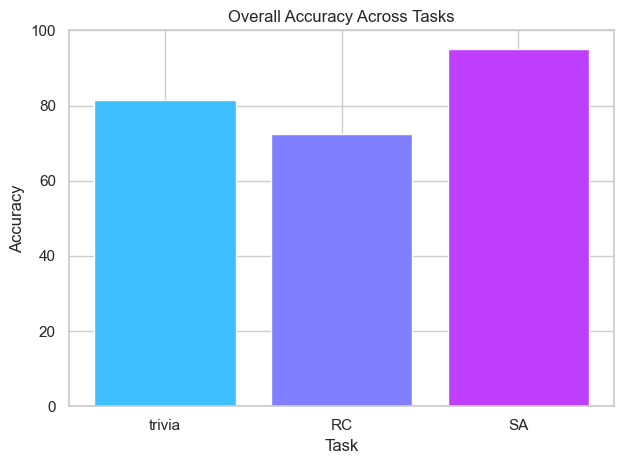

In [172]:
accuracies = df.groupby('type', observed = True)['compare_answers'].mean() * 100  # calc accuracy across tasks

# a bar plot
sns.set(style="whitegrid")  # Set a clean style
colors = sns.color_palette('cool', len(accuracies))  # a nice color palette

plt.bar(accuracies.index, accuracies.values, color=colors)
plt.title('Overall Accuracy Across Tasks')
plt.xlabel('Task')
plt.ylabel('Accuracy')
plt.ylim(0, 100)  # y-axis limited to percentage's [0, 100]
plt.tight_layout()

plt.savefig('accuracy_across_tasks.pdf')
plt.show()

Let's see the effect of the tone overall, when all tasks are considered and weighted equally.

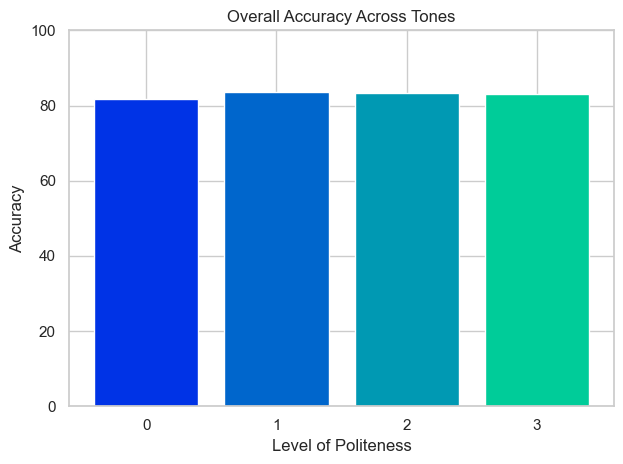

In [229]:
accuracies = df.groupby('politeness level')['compare_answers'].mean() * 100

sns.set(style="whitegrid")
colors = sns.color_palette('winter', len(accuracies))

plt.bar(accuracies.index, accuracies.values, color=colors)
plt.title('Overall Accuracy Across Tones')
plt.ylabel('Accuracy')
plt.xlabel('Level of Politeness')
plt.xticks([0, 1, 2, 3])
plt.ylim(0, 100)
plt.tight_layout()

plt.savefig('accuracy_across_tone_overall.pdf')
plt.show()

Interesting; effect's there but very small... Let's also inspect it in each tasks seperately.

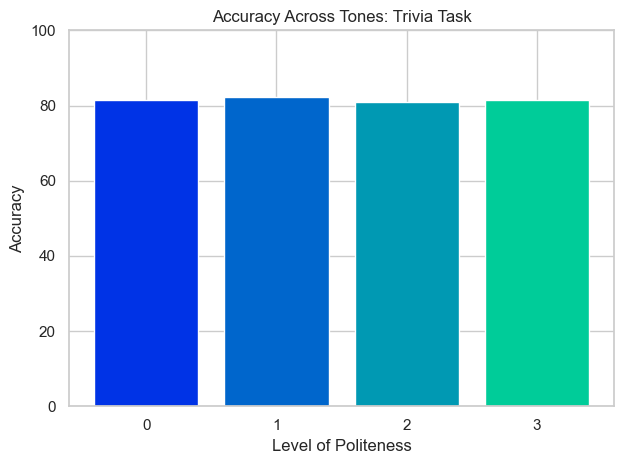

In [232]:
accuracies = df[df['type'] == 'trivia'].groupby('politeness level')['compare_answers'].mean() * 100

sns.set(style="whitegrid")
colors = sns.color_palette('winter', len(accuracies))

plt.bar(accuracies.index, accuracies.values, color=colors)
plt.title('Accuracy Across Tones: Trivia Task')
plt.ylabel('Accuracy')
plt.xlabel('Level of Politeness')
plt.xticks([0, 1, 2, 3])
plt.ylim(0, 100)
plt.tight_layout()

plt.savefig('accuracy_across_tone_trivia.pdf')
plt.show()

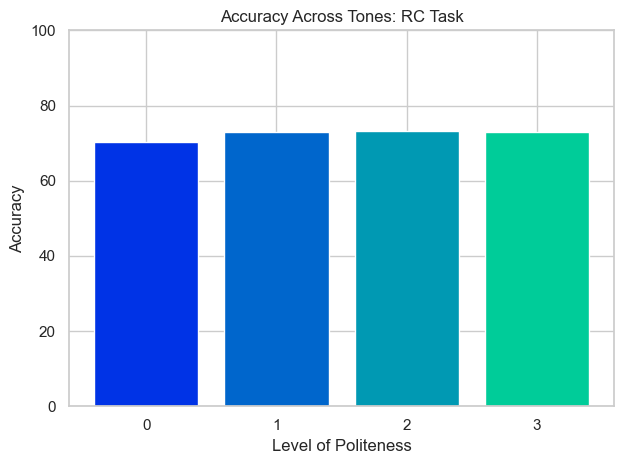

In [234]:
accuracies = df[df['type'] == 'RC'].groupby('politeness level')['compare_answers'].mean() * 100

sns.set(style="whitegrid")
colors = sns.color_palette('winter', len(accuracies))

plt.bar(accuracies.index, accuracies.values, color=colors)
plt.title('Accuracy Across Tones: RC Task')
plt.ylabel('Accuracy')
plt.xlabel('Level of Politeness')
plt.xticks([0, 1, 2, 3])
plt.ylim(0, 100)
plt.tight_layout()

plt.savefig('accuracy_across_tone_rc.pdf')
plt.show()

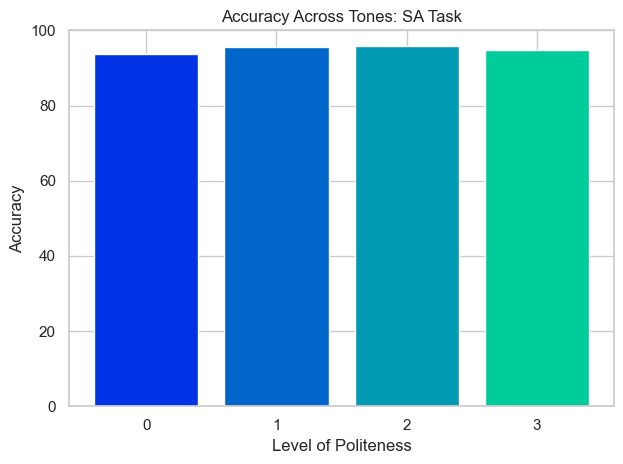

In [236]:
accuracies = df[df['type'] == 'SA'].groupby('politeness level')['compare_answers'].mean() * 100

sns.set(style="whitegrid")
colors = sns.color_palette('winter', len(accuracies))

plt.bar(accuracies.index, accuracies.values, color=colors)
plt.title('Accuracy Across Tones: SA Task')
plt.ylabel('Accuracy')
plt.xlabel('Level of Politeness')
plt.xticks([0, 1, 2, 3])
plt.ylim(0, 100)
plt.tight_layout()

plt.savefig('accuracy_across_tone_sa.pdf')
plt.show()

Although the differences between tones is steadly small, we observe that only in the SA task it is best to be 'in the middle'. Moreover, in this task it is probable that the politeness/tone markers have a clear influence on the prediction, as positive ones may cause the models to infer a positive sentiment and vice versa. Therefore, out of the mispredictions the model made, we shall check how they are divided between true positive and negative sentiments (which the model missed).

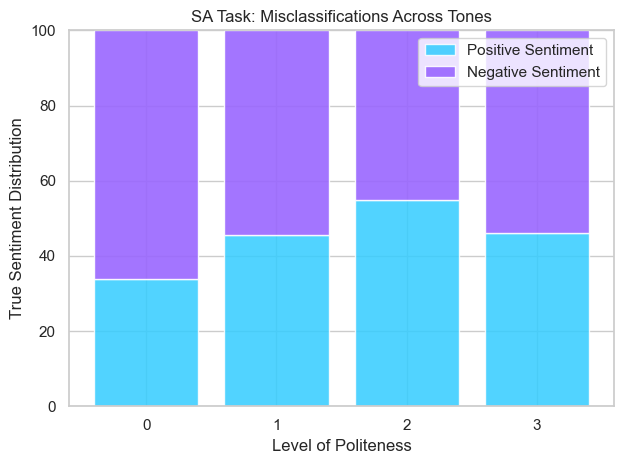

In [ ]:
misclass = df[(df['type'] == 'SA') & ~df['compare_answers']].copy()  # mispredictions made in the SA task
misclass['positive sentiment'] = misclass['correct answer'] == 1
accuracies = misclass.groupby('politeness level')['positive sentiment'].mean() * 100  # show the true label ratio for each level

sns.set(style="whitegrid")
colors = sns.color_palette('cool', len(accuracies))

# plot misclassified positive-sentiment bars
plt.bar(accuracies.index, accuracies.values, color=colors[0],
        label='Positive Sentiment', alpha=0.85)
plt.title('SA Task: Misclassifications Across Tones')
plt.ylabel('True Sentiment Distribution')
plt.xlabel('Level of Politeness')
plt.xticks([0, 1, 2, 3])
plt.ylim(0, 100)

# plot complementing negative-sentiment bars
plt.bar(
    accuracies.index, 
    100 - accuracies.values,  # as high as needed to complement to 100%
    bottom=accuracies.values,  # start right above complemented bars
    color=colors[2], 
    alpha=0.90,
    label='Negative Sentiment'
)

plt.tight_layout()
plt.legend()
plt.savefig('sa_misclassifications_across_tones.pdf')
plt.show()